In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so

In [14]:
# Different LHHW model equations
def arrhenius(temp, A, E):
    R = 8.314
    return A * np.exp((-E) / (R * temp))


def Rexp(temp, E):
    R = 8.314
    return np.exp(E / (R * temp))


def forward_lhhw_prompt(temp, c_meoh, c_h20, c_dme):
    R = 8.314
    kinetic = 71.82 * np.exp(7867 / (R * temp)) * c_meoh * c_meoh
    adsorb = (
        1
        + (3.9471e-4 * np.exp(37835 / (R * temp)) * np.sqrt(c_meoh))
        + (5.6057e-6 * np.exp(47468 / (R * temp)) * c_h20)
    )
    return kinetic / (adsorb**4)


def reverse_lhhw_prompt(temp, c_meoh, c_h20, c_dme):
    R = 8.314
    kinetic = 651.1 * np.exp((-14652) / (R * temp)) * c_dme * c_h20
    adsorb = (
        1
        + (3.9471e-4 * np.exp(37835 / (R * temp)) * np.sqrt(c_meoh))
        + (5.6057e-6 * np.exp(47468 / (R * temp)) * c_h20)
    )
    return kinetic / (adsorb**4)


def lhhw_farsi(temp, c_meoh, c_h20, c_dme):
    """
    [E_i] = J / mol
    [A_k] = mol^2 / kg / s / m^3
    [A_meoh] = m^3 / mol
    [A_h20] = m^3 / mol
    """
    A_k = 3.7e10
    E_k = -105000.0
    k = arrhenius(temp, A_k, E_k)

    A_meoh = 7.9e-4
    E_meoh = 70500
    K_meoh = arrhenius(temp, A_meoh, E_meoh)

    A_h20 = 0.84e-1
    E_h20 = 41100
    K_h20 = arrhenius(temp, A_h20, E_h20)

    K_eq = np.exp(
        (0.86 * np.log(temp))
        + (3138 / temp)
        + (1.33e-3 * temp)
        - (1.23e-5 * temp * temp)
        + (3.5e-10 * temp)
    )

    kinetic = k * (K_meoh * K_meoh)
    driving = c_meoh - ((c_dme * c_h20) / K_eq)
    adsorb = 1 + (2 * np.sqrt(K_meoh * c_meoh)) + ((K_h20 * c_h20) ** 4)

    return (kinetic * driving) / (adsorb**4)


def lhhw_turton(temp, c_meoh, c_h20, c_dme):
    """
    energy terms in exponents are kJ/mol
    C_i is in kmol/m^3
    returned rate is in kmol/m^3/h, where the volume m^3 is the reactor volume
    """
    K_eq = 0.1103 * np.exp(2708.6 / temp)
    kinetic = 1.37e10 * Rexp(temp, -2544.0)
    driving = (c_meoh * c_meoh) - ((c_dme * c_h20) / K_eq)
    adsorb = (
        1
        + (46.4e-3 * Rexp(temp, 35280.5) * np.sqrt(c_meoh))
        + (84.7e-3 * Rexp(temp, 42152.0) * c_h20)
    )
    return (kinetic * driving) / (adsorb**4)

In [29]:
# The memory use and runtime scales pretty hard - about O(n^4) - with more points.
# Add more at your own risk of being hit by the OOM reaper
#
# About 20 points (runtime ~6s) seems to be good enough for a decent fit,
# anything 50 or above is too much (runtime >4 mins).
points = 25
temp = np.linspace(325 + 273, 375 + 273, points, dtype=np.float128)
# Never start any of the concentration ranges at exactly 0.0,
# the exponents in the power law will mangle the fit
c_meoh = np.linspace(0.0001, 0.02, points, dtype=np.float128)
c_h20 = np.linspace(0.0001, 0.02, points, dtype=np.float128)
c_dme = np.linspace(0.000001, 0.0001, points, dtype=np.float128)

tempG, c_meohG, c_h20G, c_dmeG = np.meshgrid(temp, c_meoh, c_h20, c_dme, copy=False)
tempG = tempG.flatten()
c_meohG = c_meohG.flatten()
c_h20G = c_h20G.flatten()
c_dmeG = c_dmeG.flatten()

vars = (tempG, c_meohG, c_h20G, c_dmeG)
print(tempG.shape)


def power_law(vars, A, E, alpha, beta, gamma):
    """
    data[0] = temp
    data[1] = c_meoh
    data[2] = c_h20
    data[3] = c_dme
    """
    temp, c_meoh, c_h20, c_dme = vars
    k = arrhenius(temp, A, E)
    return k * (c_meoh**alpha) * (c_h20**beta) * (c_dme**gamma)


rates = lhhw_turton(tempG, c_meohG, c_h20G, c_dmeG)

(390625,)


In [30]:
%%time
# TODO: power law per stage / group of stages?

# This gets its own cell because the calculation can take multiple minutes for
# large values of `points`
popt, pcov = so.curve_fit(power_law, vars, rates)

print(popt)
print(np.diag(pcov))
print(np.linalg.cond(pcov))

/tmp/ipykernel_25987/3844463266.py:33: RuntimeWarning: overflow encountered in power
  return k * (c_meoh**alpha) * (c_h20**beta) * (c_dme**gamma)
/tmp/ipykernel_25987/3844463266.py:33: RuntimeWarning: overflow encountered in multiply
  return k * (c_meoh**alpha) * (c_h20**beta) * (c_dme**gamma)


[ 2.00634182e+00  1.48264869e-01  4.07448823e-03 -2.37118165e-03
 -1.17827251e-04]
[4.06991920e+02 2.01804313e+09 1.48905954e-01 1.44342755e-01
 1.77770431e-01]
1590073452242.4683
CPU times: user 378 ms, sys: 3.91 ms, total: 382 ms
Wall time: 380 ms


[0.84113068 0.83845512 0.83566661 ... 0.99456527 0.99456476 0.99456425]
rates=array([ 12.45218806,  12.24359345,  12.03499884, ..., 367.11063327,
       367.0742971 , 367.03796093], dtype=float128)
rates_fit=array([1.97827067, 1.9778898 , 1.97775219, ..., 1.99514665, 1.99513631,
       1.99512641], dtype=float128)
r1=1252.8834915489642
r2=2.019292388285999


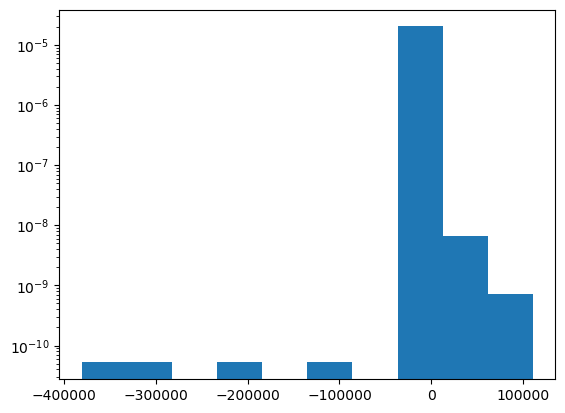

In [31]:
# Checking the rough quality of the fit
rates_fit = power_law(vars, *popt)
print(np.abs(rates - rates_fit) / rates)
print(f"{rates=}")
print(f"{rates_fit=}")
r1 = lhhw_turton(620, 0.0201, 0.0001, 0.01)
print(f"{r1=}")
r2 = power_law((620, 0.0201, 0.0001, 0.01), *popt)
print(f"{r2=}")
errors = (np.abs(rates - rates_fit) / rates).flatten() * 100  # percent error
plt.hist(errors, density=True, log=True)
plt.ticklabel_format(axis="x", style="plain")
plt.show()

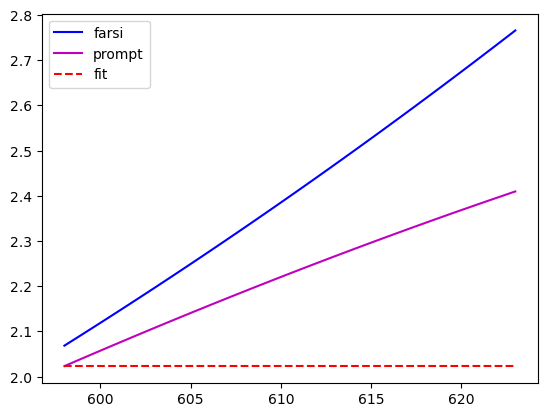

In [41]:
temp = 350 + 273
points = 100
temp = np.linspace(273 + 325, 350 + 273, points, dtype=np.float128)
c_meoh = 0.125
c_h20 = 0.0012
c_dme = 0.01
r = lhhw_turton(temp, c_meoh, c_h20, c_dme)
rf = lhhw_farsi(temp, c_meoh, c_h20, c_dme)
rp = forward_lhhw_prompt(temp, c_meoh, c_h20, c_dme) - reverse_lhhw_prompt(
    temp, c_meoh, c_h20, c_dme
)
rfit = power_law((temp, c_meoh, c_h20, c_dme), *popt)
plt.plot(temp, r, "k", label="turton")
plt.plot(temp, rf, "b", label="farsi")
plt.plot(temp, rp, "m", label="prompt")
plt.plot(temp, rfit, "r--", label="fit")
plt.legend()
plt.show()